[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/neuromatch/climate-course-content/blob/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial5.ipynb)   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/neuromatch/climate-course-content/main/tutorials/W2D1_FutureClimate-IPCCIPhysicalBasis/W2D1_Tutorial5.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>


# TO DO:

Should we:

    -remove future scenarios
    -remove question 1.2 (because it now refers to future tutorial)
    -remove last bullet on tutorial objectives

# Tutorial 1: Internal Climate Variability and Single-model Ensembles

**Week 2, Day 1, Future Climate: The Physical Basis**

**Content creators:** Brodie Pearson, Julius Busecke, Tom Nicholas

**Content reviewers:** Younkap Nina Duplex, Zahra Khodakaramimaghsoud, Sloane Garelick, Peter Ohue, Jenna Pearson, Derick Temfack, Peizhen Yang, Cheng Zhang, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Ohad Zivan, Chi Zhang

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS, Google DeepMind, and CMIP


# Tutorial Objectives

In this tutorial, we will learn about the concept of internal climate variability, how it influences the predictability of climate phenomena and how it contributes to uncertainty in CMIP6 model estimates. We will work with a *single-model ensemble*, which utilizes the *MPI-ESM1-2-LR* model from CMIP6, to isolate and quantify internal climate variability.

By the end of this tutorial, you will:

- Understand the importance of internal climate variability and its role in climate prediction and model uncertainty.
- Create and evaluate a single-model ensemble using IPCC uncertainty bands, providing a visual representation of model uncertainty.
- Contrast the uncertainty due to internal variability against the uncertainty within a multi-model ensemble (which includes internal variability _and_ the impacts of human/coding choices).

# Setup


In [7]:
# installations ( uncomment and run this cell ONLY when using google colab or kaggle )

# !pip install condacolab &> /dev/null
# import condacolab
# condacolab.install()

# # Install all packages in one call (+ use mamba instead of conda), this must in one line or code will fail
# !mamba install xarray-datatree intake-esm gcsfs xmip aiohttp nc-time-axis cf_xarray xarrayutils &> /dev/null

In [8]:
# imports
import time

tic = time.time()

import intake
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

from xmip.preprocessing import combined_preprocessing
from xmip.postprocessing import _parse_metric
from xarrayutils.plotting import shaded_line_plot

from datatree import DataTree

%matplotlib inline

##  Figure settings


In [9]:
# @title Figure settings
import ipywidgets as widgets  # interactive display

plt.style.use(
    "https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle"
)

%matplotlib inline

##  Helper functions


In [14]:
# @title Helper functions

def readin_cmip6_to_datatree(facet_dict):
    # open an intake catalog containing the Pangeo CMIP cloud data
    col = intake.open_esm_datastore(
        "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
    )

    # from the full `col` object, create a subset using facet search
    cat = col.search(
        source_id=facet_dict['source_id'],
        variable_id=facet_dict['variable_id'],
        member_id=facet_dict['member_id'],
        table_id=facet_dict['table_id'],
        grid_label=facet_dict['grid_label'],
        experiment_id=facet_dict['experiment_id'],
        require_all_on=facet_dict['require_all_on']  # make sure that we only get models which have all of the above experiments
    )

    # convert the sub-catalog into a datatree object, by opening each dataset into an xarray.Dataset (without loading the data)
    kwargs = dict(
        preprocess=combined_preprocessing,  # apply xMIP fixes to each dataset
        xarray_open_kwargs=dict(
            use_cftime=True
        ),  # ensure all datasets use the same time index
        storage_options={
            "token": "anon"
        },  # anonymous/public authentication to google cloud storage
    )

    cat.esmcat.aggregation_control.groupby_attrs = ["source_id", "experiment_id"]
    dt = cat.to_datatree(**kwargs)
    
    return dt



def global_mean(ds: xr.Dataset) -> xr.Dataset:
    """Global average, weighted by the cell area"""
    return ds.weighted(ds.areacello.fillna(0)).mean(["x", "y"], keep_attrs=True)


# Calculate anomaly to reference period
def datatree_anomaly(dt):
    dt_out = DataTree()
    for model, subtree in dt.items():
        # for the coding exercise, ellipses will go after sel on the following line
        ref = dt[model]["historical"].ds.sel(time=slice("1950", "1980")).mean()
        dt_out[model] = subtree - ref
    return dt_out

##  Video 1: Internal Climate Variability


In [11]:
# @title Video 1: Internal Climate Variability

from ipywidgets import widgets
from IPython.display import YouTubeVideo
from IPython.display import IFrame
from IPython.display import display


class PlayVideo(IFrame):
    def __init__(self, id, source, page=1, width=400, height=300, **kwargs):
        self.id = id
        if source == "Bilibili":
            src = f"https://player.bilibili.com/player.html?bvid={id}&page={page}"
        elif source == "Osf":
            src = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{id}/?direct%26mode=render"
        super(PlayVideo, self).__init__(src, width, height, **kwargs)


def display_videos(video_ids, W=400, H=300, fs=1):
    tab_contents = []
    for i, video_id in enumerate(video_ids):
        out = widgets.Output()
        with out:
            if video_ids[i][0] == "Youtube":
                video = YouTubeVideo(
                    id=video_ids[i][1], width=W, height=H, fs=fs, rel=0
                )
                print(
                    f"Video available at https://youtube.com/watch?v={video.id}")
            else:
                video = PlayVideo(
                    id=video_ids[i][1],
                    source=video_ids[i][0],
                    width=W,
                    height=H,
                    fs=fs,
                    autoplay=False,
                )
                if video_ids[i][0] == "Bilibili":
                    print(
                        f"Video available at https://www.bilibili.com/video/{video.id}"
                    )
                elif video_ids[i][0] == "Osf":
                    print(f"Video available at https://osf.io/{video.id}")
            display(video)
        tab_contents.append(out)
    return tab_contents


video_ids = [("Youtube", "YcIAaljLRh4"), ("Bilibili", "BV1HF41197qn")]
tab_contents = display_videos(video_ids, W=730, H=410)
tabs = widgets.Tab()
tabs.children = tab_contents
for i in range(len(tab_contents)):
    tabs.set_title(i, video_ids[i][0])
display(tabs)

In [12]:
# @markdown
from ipywidgets import widgets
from IPython.display import IFrame

link_id = "cy5bh"

download_link = f"https://osf.io/download/{link_id}/"
render_link = f"https://mfr.ca-1.osf.io/render?url=https://osf.io/{link_id}/?direct%26mode=render%26action=download%26mode=render"
# @markdown
out = widgets.Output()
with out:
    print(f"If you want to download the slides: {download_link}")
    display(IFrame(src=f"{render_link}", width=730, height=410))
display(out)

Output()

# Section 1: Internal Climate Variability & Single-model Ensembles

One of the CMIP6 models we are using in today's tutorials, _MPI-ESM1-2-LR_, is part of single-model ensemble, where its modelling centre carried out multiple simulations of the model for many of the CMIP6 experiments. To create a single-model ensemble, the modelling centre will run a model using the same forcing data, but with small changes in the initial conditions. Due to the chaotic nature of the climate system, these small changes in initial conditions lead to differences in the modelled climate as time progresses. These differences are often referred to as internal variability. By running this single-model ensemble and comparing the results to simulations using different forcing datasets, it allows us to separate the internal variability from the externally-forced variability. If you are interested in learning more about large ensemble climate models, you can [read this paper](https://esd.copernicus.org/articles/12/401/2021/).

Let's take advantage of this single-model ensemble to quantify the internal variability of this model's simulated climate, and contrast this against the multi-model uncertainty we diagnosed in the previous tutorial.


## Section 1.1: Loading CMIP6 SST Data with `xarray`

As a reminder, these ESMs simulate several systems (ocean, atmosphere, cryosphere, land) that are coupled to each other, and each system has its own variables, physics, and discretizations (grid & timestep).

<img src="https://upload.wikimedia.org/wikipedia/commons/7/73/AtmosphericModelSchematic.png" alt= “EarthSystemModel” width="420" height="400">

Atmospheric Model Schematic (Credit: [Wikipedia](https://upload.wikimedia.org/wikipedia/commons/7/73/AtmosphericModelSchematic.png))

Let's repeat the CMIP6 loading method that we learned in Tutorial 6 on last week's Climate Modelling day (Day 5).

 **Although we will only work with monthly SST (ocean) data today, the methods introduced can easily be applied/extended to load and analyze other CMIP6 variables, including from other components of the Earth system.**
 
To learn more about CMIP, including additional methods to access CMIP data, please see our [CMIP Resource Bank](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md) and the [CMIP website](https://wcrp-cmip.org/).

As a reminder, the *facets* that have to be specified for CMIP6, along with the facet choice(s) we make in this tutorial, are:
1. **variable_id**: *tos* = sea surface temperature
2. **source_id**: The CMIP6 model(s) that we want data from 
3. **table_id**: *Omon* (ocean monthly output)
4. **grid_id**: *gn* = data on the model's *native* grid
5. **experiment_id**: *ssp585* (we'll discuss experiments later today)
6. **member_id**: *r1i1p1f1* for now

Now, let's repeat our CMIP6 loading method from the previous tutorial.


## Coding Exercise 1.1

Complete the following code to:

1.  Load 5 different _realizations_ of the _MPI-ESM1-2-LR_ experiments (_r1i1p1f1_ through _r5i1p1f1_). This numbering convention means they were each initialized using a different time-snapshot of the base/spin-up simulation.
2.  Plot the _historical_ experiment data for each realization, using a distinct color for each realization.


In [19]:
facet_dict = { "source_id":"MPI-ESM1-2-LR",
    "variable_id":"tos",
    "member_id":["r1i1p1f1", "r2i1p1f1", "r3i1p1f1", "r4i1p1f1", "r5i1p1f1"],
    "table_id":"Omon",
    "grid_label":"gn",
    "experiment_id":"historical",
    "require_all_on":["source_id", "member_id"]
    }

facet_dict_area = { "source_id":"MPI-ESM1-2-LR",
    "variable_id":"areacello",
    "member_id":"r1i1p1f1",
    "table_id":"Ofx",
    "grid_label":"gn",
    "experiment_id":"historical",
    "require_all_on":"source_id"
    }

dt_ensemble = readin_cmip6_to_datatree(facet_dict)
dt_area = readin_cmip6_to_datatree(facet_dict_area)


# add the area (we can reuse the area from before, since for a given model the horizontal area does not vary between members)
dt_ensemble_with_area = DataTree()
for model, subtree in dt_ensemble.items():
    metric = dt_area["MPI-ESM1-2-LR"]["historical"].ds["areacello"].squeeze()
    dt_ensemble_with_area[model] = subtree.map_over_subtree(_parse_metric, metric)

# global average
# average every dataset in the tree globally
dt_ensemble_gm = dt_ensemble_with_area.map_over_subtree(global_mean)

# calculate anomaly
dt_ensemble_gm_anomaly = datatree_anomaly(dt_ensemble_gm)

# coarsen data for plotting the historical values of the 5 members
dt_ensemble_gm_anomaly_hist = dt_ensemble_gm_anomaly['MPI-ESM1-2-LR']['historical'].ds.coarsen(time=12).mean().tos


--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'



--> The keys in the returned dictionary of datasets are constructed as follows:
	'source_id/experiment_id'


Text(0.5, 0, 'Year')

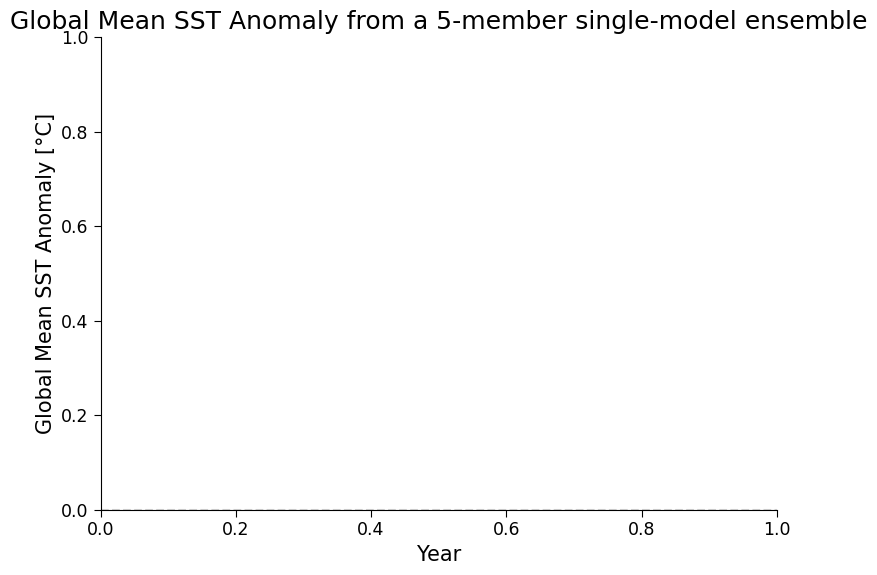

In [20]:
fig, ax = plt.subplots()
# plot the data dt_ensemble_gm_anomaly_hist with a different color for each member id
...

ax.set_title(
    "Global Mean SST Anomaly from a 5-member single-model ensemble"
)

plt.axhline(0, linestyle='dashed', color='lightgrey')
ax.set_ylabel("Global Mean SST Anomaly [°C]")
ax.set_xlabel("Year")

Text(0.5, 0, 'Year')

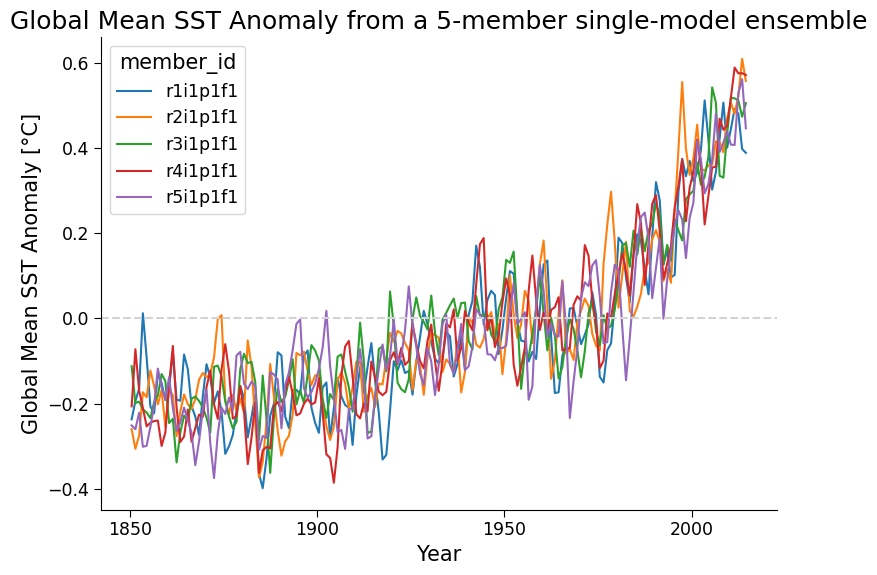

In [21]:
# To remove solution
fig, ax = plt.subplots()
dt_ensemble_gm_anomaly_hist.plot(hue='member_id')

ax.set_title(
    "Global Mean SST Anomaly from a 5-member single-model ensemble"
)

plt.axhline(0, linestyle='dashed', color='lightgrey')
ax.set_ylabel("Global Mean SST Anomaly [°C]")
ax.set_xlabel("Year")

### **Coding Exercise 1.2**

Complete the following code to:

1.  Plot the mean SST anomaly of the single-model ensemble, with an envelop visualizing the spread across members (excluding the lowest and higest 17%)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


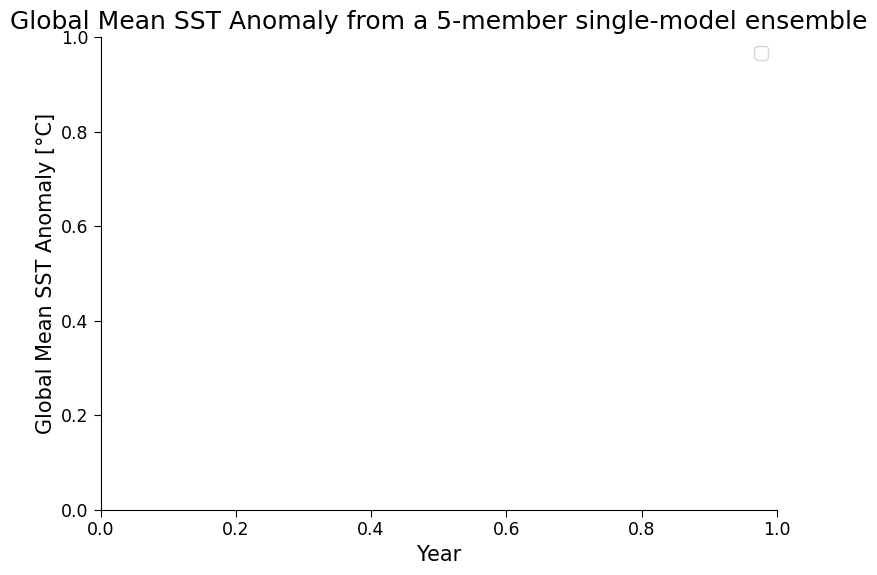

In [22]:
fig, ax = plt.subplots()

da = (
    dt_ensemble_gm_anomaly["MPI-ESM1-2-LR"]['historical']
    .ds.tos.coarsen(time=12)
    .mean()
    .load()
)
# calculate the mean across ensemble members
da_mean = ...
# Uncomment below after filling in above ellipses
#da_mean.plot(color='C0', label='ensemble mean', ax=ax)

# shading representing spread between members
x = da.time.data
# diagnose the lower range of the likely bounds
da_lower = ...
# diagnose the upper range of the likely bounds
da_upper = ...
# Uncomment below after filling in above ellipses
#ax.fill_between(x, da_lower, da_upper, alpha=0.5, color='C0')

ax.set_title(
    "Global Mean SST Anomaly from a 5-member single-model ensemble"
)
ax.set_ylabel("Global Mean SST Anomaly [°C]")
ax.set_xlabel("Year")
ax.legend()

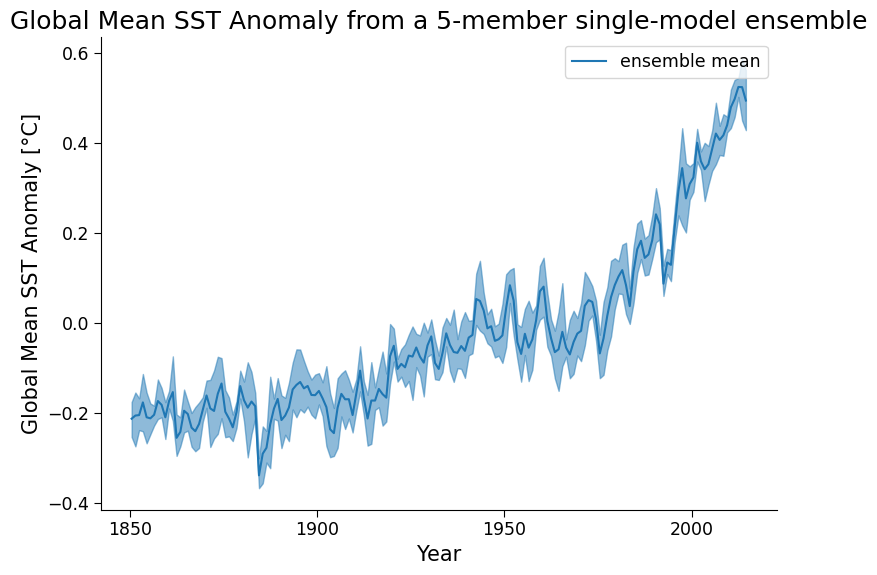

In [23]:
#To remove solution
fig, ax = plt.subplots()

da = (
    dt_ensemble_gm_anomaly["MPI-ESM1-2-LR"]['historical']
    .ds.tos.coarsen(time=12)
    .mean()
    .load()
)
# calculate the mean across ensemble members
da.mean("member_id").plot(color='C0', label='ensemble mean', ax=ax)

# shading representing spread between members
x = da.time.data
# diagnose the lower range of the likely bounds
da_lower = da.squeeze().quantile(0.17, dim="member_id")
# diagnose the upper range of the likely bounds
da_upper = da.squeeze().quantile(0.83, dim="member_id")
# Uncomment below after filling in above ellipses
ax.fill_between(x, da_lower, da_upper, alpha=0.5, color='C0')

ax.set_title(
    "Global Mean SST Anomaly from a 5-member single-model ensemble"
)
ax.set_ylabel("Global Mean SST Anomaly [°C]")
ax.set_xlabel("Year")
ax.legend()

# Summary

In this tutorial, we explored the internal climate variability and its implications for climate modeling and prediction. We discussed the utility of single-model ensembles for isolating the effects of internal variability by contrasting simulations with identical physics, numerics, and discretization. We quantified the internal variability of _MPI-ESM1-2-LR_ model's simulated climate. Through this tutorial, we better understand the boundaries of climate prediction and internal variability as a source of uncertainty in CMIP6 models.


# Resources

This tutorial uses data from the simulations conducted as part of the [CMIP6](https://wcrp-cmip.org/) multi-model ensemble.

For examples on how to access and analyze data, please visit the [Pangeo Cloud CMIP6 Gallery](https://gallery.pangeo.io/repos/pangeo-gallery/cmip6/index.html)

For more information on what CMIP is and how to access the data, please see this [page](https://github.com/ClimateMatchAcademy/course-content/blob/main/tutorials/CMIP/CMIP_resource_bank.md).

For more information about large ensemble climate modelling [see this paper](https://esd.copernicus.org/articles/12/401/2021/).
